In [1]:
using Revise

In [2]:
using
    QuantumStates,
    OpticalBlochEquations,
    DifferentialEquations,
    UnitsToValue,
    LinearAlgebra,
    Printf,
    Plots,
    # DiffEqNoiseProcess,
    Random,
    StatsBase
;

using Distributions

import MutableNamedTuples: MutableNamedTuple
import StructArrays: StructArray, StructVector
import StaticArrays: @SVector, SVector
import LinearAlgebra: norm, ⋅, adjoint!, diag
import LoopVectorization: @turbo
using BenchmarkTools
using Parameters
using LsqFit

import ProgressMeter: Progress, next!

const λ = 663.3e-9
const Γ = 2π * 6.6e6
const m = @with_unit 107 "u"
const k = 2π / λ
_μB = (μ_B / h) * 1e-4;

In [3]:
function Gaussian(x, p)
    σ, x0, A = p
   return A * exp.(-(x.-x0).^2/(2*σ^2)) 
end;

### Hamiltonian for SrF

In [4]:
QN_bounds = (
    S = 1/2, 
    I = 1/2, 
    Λ = 0, 
    N = 1
)
X_state_basis = enumerate_states(HundsCaseB_Rot, QN_bounds)

X_state_operator = :(
    BX * Rotation + 
    DX * RotationDistortion + 
    γX * SpinRotation + 
    bFX * Hyperfine_IS + 
    cX * (Hyperfine_Dipolar/3)
)

X_state_parameters = @params begin
    BX = 0.25359 * 299792458 * 1e-4
    DX = 2.49e-7 * 299792458 * 1e-4
    γX = 74.79485
    bX = 97.0834
    cX = 30.268
end
X_state_parameters.param_dict[:bFX] = X_state_parameters.bX + X_state_parameters.cX / 3;

X_state_ham = Hamiltonian(basis=X_state_basis, operator=X_state_operator, parameters=X_state_parameters)

# Add Zeeman terms
Zeeman_x(state, state′) = (Zeeman(state, state′,-1) - Zeeman(state, state′,1))/sqrt(2)
Zeeman_y(state, state′) = im*(Zeeman(state, state′,-1) + Zeeman(state, state′,1))/sqrt(2)
Zeeman_z(state, state′) = Zeeman(state, state′, 0)

X_state_ham = add_to_H(X_state_ham, :B_x, (gS * _μB * 1e-6) * Zeeman_x)
X_state_ham = add_to_H(X_state_ham, :B_y, (gS * _μB * 1e-6) * Zeeman_y)
X_state_ham = add_to_H(X_state_ham, :B_z, (gS * _μB * 1e-6) * Zeeman_z)
X_state_ham.parameters.B_x = 0.
X_state_ham.parameters.B_y = 0.
X_state_ham.parameters.B_z = 0.

evaluate!(X_state_ham)
QuantumStates.solve!(X_state_ham)
;

QN_bounds = (
    S = 1/2,
    I = 1/2,
    Λ = (-1,1),
    J = 1/2:5/2
)
A_state_basis = enumerate_states(HundsCaseA_Rot, QN_bounds)

A_state_operator = :(
    T_A * DiagonalOperator +
    Be_A * Rotation + 
    Aso_A * SpinOrbit + 
    q_A * ΛDoubling_q +
    p_A * ΛDoubling_p2q + q_A * (2ΛDoubling_p2q) +
    B_z * Zeeman_L +
    b00_A * (Hyperfine_IF - Hyperfine_IL)
);

A_state_parameters = @params begin
    T_A = 15072.09 * 299792458 * 1e-4
    Be_A =  0.2536135 * 299792458 * 1e-4
    Aso_A = 281.46138 * 299792458 * 1e-4
    b00_A = 0.
    p_A = -0.133002 * 299792458 * 1e-4
    q_A = -0.3257e-3 * 299792458 * 1e-4
    B_z = 0.
end;

A_state_ham = Hamiltonian(basis=A_state_basis, operator=A_state_operator, parameters=A_state_parameters)
evaluate!(A_state_ham)
QuantumStates.solve!(A_state_ham)
;

A_state_J12_pos_parity_states = A_state_ham.states[5:8]

QN_bounds = (
    S = 1/2, 
    I = 1/2, 
    Λ = (-1,1), 
    N = 0:3
)
A_state_caseB_basis = enumerate_states(HundsCaseB_Rot, QN_bounds)

ground_states = X_state_ham.states
excited_states = convert_basis(A_state_J12_pos_parity_states, A_state_caseB_basis)

states = [ground_states; excited_states]

for state ∈ states
    state.E *= 1e6
end
;

d = zeros(ComplexF64, 16, 16, 3)
d_ge = zeros(ComplexF64, 12, 4, 3)

basis_tdms = get_tdms_two_bases(X_state_ham.basis, A_state_caseB_basis, TDM)
tdms_between_states!(d_ge, basis_tdms, ground_states, excited_states)
d[1:12, 13:16, :] .= d_ge
;

In [5]:
function update_H(H, p, r, τ)
    Zeeman_Hz = p.extra_p.Zeeman_Hz
    Zeeman_Hx = p.extra_p.Zeeman_Hx
    Zeeman_Hy = p.extra_p.Zeeman_Hy
    
    gradient_z = p.extra_p.gradient_z
    gradient_x = p.extra_p.gradient_x
    gradient_y = p.extra_p.gradient_y
    @turbo for i in eachindex(H)
        H.re[i] = gradient_z * Zeeman_Hz.re[i] * r[3] + gradient_x * Zeeman_Hx.re[i] * r[1] + gradient_y * Zeeman_Hy.re[i] * r[2]
        H.im[i] = gradient_z * Zeeman_Hz.im[i] * r[3] + gradient_x * Zeeman_Hx.im[i] * r[1] + gradient_y * Zeeman_Hy.im[i] * r[2]
    end
    return nothing
end

function randomize_initial_vector!(p, r_dist, v_dist)
    n_excited = extra_p.n_excited
    n_states = length(p.states)
    p.ψ[n_states + n_excited + 1] = rand(r_dist)*k
    p.ψ[n_states + n_excited + 2] = rand(r_dist)*k
    p.ψ[n_states + n_excited + 3] = rand(r_dist)*k
    p.ψ[n_states + n_excited + 4] = rand(v_dist)*k/Γ
    p.ψ[n_states + n_excited + 5] = rand(v_dist)*k/Γ
    p.ψ[n_states + n_excited + 6] = rand(v_dist)*k/Γ
end
;

In [6]:
function operator_to_matrix(A, states)
    """
    Write an operator as a matrix in basis {states}.
    """
    n_states = length(states)
    A_mat = zeros(ComplexF64, n_states, n_states)
    for i in 1:n_states
        for j in 1:n_states
            A_mat[i,j] = extend_operator(A, states[i], states[j])
        end
    end
    return A_mat
end

function operator_to_matrix_zero_padding2(OA, A_states, B_states)
    """
    OA is an operator on Hilbert space A (basis = A_states).
    We would like to extend A to the direct-sum space A ⨁ B by padding with zeros, i.e.
    <i|OAB|j> = 0 if i∉A or j∉A, <i|OAB|j> = <i|OA|j> if i∈A and j∈A.
    """
    n_A = length(A_states)
    n_B = length(B_states)
    OAB_mat = zeros(ComplexF64, n_A+n_B, n_A+n_B)
    OAB_mat[1:n_A, 1:n_A] .= operator_to_matrix(OA, A_states)
    return OAB_mat
end
;

In [7]:
Zeeman_x_mat = StructArray(operator_to_matrix_zero_padding2(Zeeman_x, ground_states, excited_states) .* (2π*gS*_μB/Γ))
Zeeman_y_mat = StructArray(operator_to_matrix_zero_padding2(Zeeman_y, ground_states, excited_states) .* (2π*gS*_μB/Γ))
Zeeman_z_mat = StructArray(operator_to_matrix_zero_padding2(Zeeman_z, ground_states, excited_states) .* (2π*gS*_μB/Γ))
;

In [8]:
function init_isotropic_MOT_distribution(T, diameter)
    kB = 1.381e-23
    m = @with_unit 57 "u"
    σ = sqrt(kB * T / m)
    
    r = Normal(0, diameter)
    v = Normal(0, σ)
    return r, v
end

function init_MOT_distribution(T, diameter,displacement,kick)
    kB = 1.381e-23
    m = @with_unit 57 "u"
    σ = sqrt(kB * T / m)
    
    r = Normal(displacement, diameter)
    v = Normal(kick, σ)
    return r, v
end

function randomize_initial_vector!(p, x_dist, y_dist, z_dist, vx_dist, vy_dist, vz_dist)
    n_excited = extra_p.n_excited
    n_states = length(p.states)
    p.ψ[n_states + n_excited + 1] = rand(x_dist)*k
    p.ψ[n_states + n_excited + 2] = rand(y_dist)*k
    p.ψ[n_states + n_excited + 3] = rand(z_dist)*k
    p.ψ[n_states + n_excited + 4] = rand(vx_dist)*k/Γ
    p.ψ[n_states + n_excited + 5] = rand(vy_dist)*k/Γ
    p.ψ[n_states + n_excited + 6] = rand(vz_dist)*k/Γ
end

function fixed_initial_vector!(p, x, y, z, vx, vy, vz)
     n_excited = extra_p.n_excited
    n_states = length(p.states)
    p.ψ[n_states + n_excited + 1] = x*k
    p.ψ[n_states + n_excited + 2] = y*k
    p.ψ[n_states + n_excited + 3] = z*k
    p.ψ[n_states + n_excited + 4] = vx*k/Γ
    p.ψ[n_states + n_excited + 5] = vy*k/Γ
    p.ψ[n_states + n_excited + 6] = vz*k/Γ
end

function random_initial_state!(p)
    n_excited = extra_p.n_excited
    n_states = length(p.states)
   rn = rand() * (n_states - n_excited)
    i = Int(floor(rn))+1
    p.ψ[1:n_states].=0.0
    p.ψ[i] = 1.0
end
;

In [9]:
function initialize_lasers()   

    flip(ϵ) = (ϵ == σ⁻) ? σ⁺ : σ⁻
    
    Δ1 = +2.0Γ
    Δ2 = -0.5Γ 
    Δ3 = +3.0Γ 
    Δ4 = +4.0Γ

    s_func(s0) = t -> s0
    
    s1 = s_func(5 * 60/31)
    s2 = s_func(1 * 60/31)
    s3 = s_func(5 * 60/31)
    s4 = s_func(20 * 60/31)

    # s1 *= 4
    # s2 *= 4
    # s3 *= 4
    # s4 *= 4

    pol1 = σ⁻
    pol2 = σ⁺
    pol3 = σ⁻
    pol4 = σ⁺

    Φ1 = exp(im*2π*rand())
    Φ2 = exp(im*2π*rand())
    Φ3 = exp(im*2π*rand())
    Φ4 = exp(im*2π*rand())
    Φ5 = exp(im*2π*rand())
    Φ6 = exp(im*2π*rand())

    ω1 = 2π * (energy(states[end]) - energy(states[1])) + Δ1
    ω2 = 2π * (energy(states[end]) - energy(states[4])) + Δ2
    ω3 = 2π * (energy(states[end]) - energy(states[5])) + Δ3
    ω4 = 2π * (energy(states[end]) - energy(states[9])) + Δ4

    ϵ_(ϵ, f) = t -> ϵ
    # ϵ_(ϵ, f) = t -> exp(-im*2π*f*t/50) .* ϵ

    k̂ = +x̂; ϵ1 = Φ1.*rotate_pol(pol1, k̂); ϵ_func1 = ϵ_(ϵ1, 1.00); laser1 = Field(k̂, ϵ_func1, ω1, s1)
    k̂ = -x̂; ϵ2 = Φ2.*rotate_pol(pol1, k̂); ϵ_func2 = ϵ_(ϵ2, 0.99); laser2 = Field(k̂, ϵ_func2, ω1, s1)
    k̂ = +ŷ; ϵ3 = Φ3.*rotate_pol(pol1, k̂); ϵ_func3 = ϵ_(ϵ3, 0.98); laser3 = Field(k̂, ϵ_func3, ω1, s1)
    k̂ = -ŷ; ϵ4 = Φ4.*rotate_pol(pol1, k̂); ϵ_func4 = ϵ_(ϵ4, 0.97); laser4 = Field(k̂, ϵ_func4, ω1, s1)
    k̂ = +ẑ; ϵ5 = Φ5.*rotate_pol(flip(pol1), k̂); ϵ_func5 = ϵ_(ϵ5, 0.96); laser5 = Field(k̂, ϵ_func5, ω1, s1)
    k̂ = -ẑ; ϵ6 = Φ6.*rotate_pol(flip(pol1), k̂); ϵ_func6 = ϵ_(ϵ6, 0.95); laser6 = Field(k̂, ϵ_func6, ω1, s1)

    lasers_1 = [laser1, laser2, laser3, laser4, laser5, laser6]

    k̂ = +x̂; ϵ7 = Φ1.*rotate_pol(pol2, k̂); ϵ_func7 = ϵ_(ϵ7, 0.94); laser7 = Field(k̂, ϵ_func7, ω2, s2)
    k̂ = -x̂; ϵ8 = Φ2.*rotate_pol(pol2, k̂); ϵ_func8 = ϵ_(ϵ8, 0.93); laser8 = Field(k̂, ϵ_func8, ω2, s2)
    k̂ = +ŷ; ϵ9 = Φ3.*rotate_pol(pol2, k̂); ϵ_func9 = ϵ_(ϵ9, 0.92); laser9 = Field(k̂, ϵ_func9, ω2, s2)
    k̂ = -ŷ; ϵ10 = Φ4.*rotate_pol(pol2, k̂); ϵ_func10 = ϵ_(ϵ10, 0.91); laser10 = Field(k̂, ϵ_func10, ω2, s2)
    k̂ = +ẑ; ϵ11 = Φ5.*rotate_pol(flip(pol2), k̂); ϵ_func11 = ϵ_(ϵ11, 0.90); laser11 = Field(k̂, ϵ_func11, ω2, s2)
    k̂ = -ẑ; ϵ12 = Φ6.*rotate_pol(flip(pol2), k̂); ϵ_func12 = ϵ_(ϵ12, 0.89); laser12 = Field(k̂, ϵ_func12, ω2, s2)

    lasers_2 = [laser7, laser8, laser9, laser10, laser11, laser12]

    k̂ = +x̂; ϵ13 = Φ1.*rotate_pol(pol3, k̂); ϵ_func13 = ϵ_(ϵ13, 0.88); laser13 = Field(k̂, ϵ_func13, ω3, s3)
    k̂ = -x̂; ϵ14 = Φ2.*rotate_pol(pol3, k̂); ϵ_func14 = ϵ_(ϵ14, 0.87); laser14 = Field(k̂, ϵ_func14, ω3, s3)
    k̂ = +ŷ; ϵ15 = Φ3.*rotate_pol(pol3, k̂); ϵ_func15 = ϵ_(ϵ15, 0.86); laser15 = Field(k̂, ϵ_func15, ω3, s3)
    k̂ = -ŷ; ϵ16 = Φ4.*rotate_pol(pol3, k̂); ϵ_func16 = ϵ_(ϵ16, 0.85); laser16 = Field(k̂, ϵ_func16, ω3, s3)
    k̂ = +ẑ; ϵ17 = Φ5.*rotate_pol(flip(pol3), k̂); ϵ_func17 = ϵ_(ϵ17, 0.84); laser17 = Field(k̂, ϵ_func17, ω3, s3)
    k̂ = -ẑ; ϵ18 = Φ6.*rotate_pol(flip(pol3), k̂); ϵ_func18 = ϵ_(ϵ18, 0.83); laser18 = Field(k̂, ϵ_func18, ω3, s3)

    lasers_3 = [laser13, laser14, laser15, laser16, laser17, laser18]

    k̂ = +x̂; ϵ19 = Φ1.*rotate_pol(pol4, k̂); ϵ_func19 = ϵ_(ϵ19, 0.82); laser19 = Field(k̂, ϵ_func19, ω4, s4)
    k̂ = -x̂; ϵ20 = Φ2.*rotate_pol(pol4, k̂); ϵ_func20 = ϵ_(ϵ20, 0.81); laser20 = Field(k̂, ϵ_func20, ω4, s4)
    k̂ = +ŷ; ϵ21 = Φ3.*rotate_pol(pol4, k̂); ϵ_func21 = ϵ_(ϵ21, 0.80); laser21 = Field(k̂, ϵ_func21, ω4, s4)
    k̂ = -ŷ; ϵ22 = Φ4.*rotate_pol(pol4, k̂); ϵ_func22 = ϵ_(ϵ22, 0.79); laser22 = Field(k̂, ϵ_func22, ω4, s4)
    k̂ = +ẑ; ϵ23 = Φ5.*rotate_pol(flip(pol4), k̂); ϵ_func23 = ϵ_(ϵ23, 0.78); laser23 = Field(k̂, ϵ_func23, ω4, s4)
    k̂ = -ẑ; ϵ24 = Φ6.*rotate_pol(flip(pol4), k̂); ϵ_func24 = ϵ_(ϵ24, 0.77); laser24 = Field(k̂, ϵ_func24, ω4, s4)

    lasers_4 = [laser19, laser20, laser21, laser22, laser23, laser24]

    lasers = [lasers_1; lasers_2; lasers_3; lasers_4]
    return lasers
end
;

In [10]:
function condition(u,t,integrator)
    p = integrator.p
    integrated_excited_pop = 0.0
    for i ∈ 1:p.n_excited
        integrated_excited_pop += real(u[p.n_states+i])
    end
    _condition = integrated_excited_pop - p.extra_p.time_to_decay
    
    # terminate if the particle is more than 20mm from the centre
    r = 0.0
    for i ∈ 1:3
        r += norm(u[p.n_states + p.n_excited + i])^2
    end
    r = sqrt(r)
    if r >= 5e-3*k
       terminate!(integrator)
    end
    
    return _condition
end
;

In [17]:
n_states = length(states)
particle = OpticalBlochEquations.Particle()
ψ₀ = zeros(ComplexF64, n_states)
ψ₀[1] = 1.0
H₀ = zeros(ComplexF64, n_states, n_states)

n_excited=length(excited_states)

decay_dist = Exponential(1)
extra_p = MutableNamedTuple(
    Zeeman_Hx=Zeeman_x_mat,
    Zeeman_Hy=Zeeman_y_mat,
    Zeeman_Hz=Zeeman_z_mat,
    gradient_z=+29e2/k,
    gradient_x=+29e2/k/2,
    gradient_y=-29e2/k/2, # should be -1 but has wrong sign of Zeeman interaction
    decay_dist=decay_dist,
    time_to_decay=rand(decay_dist),
    n_excited = n_excited
    )

t_span = (0, 25e-3) ./ (1/Γ);

In [ ]:
lasers = initialize_lasers()

dT = 0.1
save_every = 10000
p = schrodinger_stochastic(particle, states, lasers, d, ψ₀, m/(ħ*k^2/Γ), dT, save_every, n_excited;
extra_p=extra_p, λ=λ, Γ=Γ, update_H=update_H)

cb = ContinuousCallback(condition, SE_collapse_pol_always!, nothing, save_positions=(false,false))
prob = ODEProblem(ψ_stochastic!, p.ψ, t_span, p)

# randomize_initial_vector!(prob.p, x_dist, y_dist, z_dist, vx_dist, vy_dist, vz_dist)
fixed_initial_vector!(prob.p, 1e-3, 1e-3, 1e-3, 0, 0, 0)
random_initial_state!(prob.p)

using Logging: global_logger
using TerminalLoggers: TerminalLogger
global_logger(TerminalLogger())

@time sol = DifferentialEquations.solve(prob, DP5(), reltol=1e-3, callback=cb, saveat=1000, maxiters=10000000, progress=true, progress_steps=1000000);

ODE   0%|█                                              |  ETA: N/A

In [ ]:
plot_ts = sol.t
plot_us = sol.u

plot()
for i in n_states + length(excited_states) +1 :n_states + length(excited_states) + 3
    plot!(plot_ts/Γ*1e3, [real(u[i]) for u in plot_us]./k*1e3)
end
plot!(legend=true, title="position", xlabel="time (ms)",ylabel="position (mm)")

In [ ]:
plot()
for i in n_states + length(excited_states) + 4:n_states + length(excited_states) + 6
    plot!(plot_ts/Γ*1e3, [real(u[i]) for u in plot_us]./k*Γ)
end
sol_vz = [real(u[n_states + length(excited_states) + 6]) for u in sol.u].*(Γ/k);
v2 = mean(sol_vz[end-length(sol_vz)÷2:end].^2)
k_B = 1.381e-23
@printf("Final temperature = %.2e K", m*v2/k_B)
plot!(legend=true, title="velocity", xlabel="time (ms)",ylabel="velocity (m/s)")

In [ ]:
p.n_scatters

In [ ]:
println("Scattering rate:")
p.n_scatters / (t_span[end] / Γ)

# Propagating multiple particles

In [ ]:
n_values = 200
n_threads=Threads.nthreads()
batch_size = fld(n_values, n_threads)
remainder = n_values - batch_size * n_threads
prog_bar = Progress(n_values)

x_trajectories = Array{Vector{Float64}}(undef, n_values) 
y_trajectories = Array{Vector{Float64}}(undef, n_values) 
z_trajectories = Array{Vector{Float64}}(undef, n_values) 
x_velocities = Array{Vector{Float64}}(undef, n_values) 
y_velocities = Array{Vector{Float64}}(undef, n_values) 
z_velocities = Array{Vector{Float64}}(undef, n_values) 
A_populations = Array{Vector{Float64}}(undef, n_values) 
times = Array{Vector{Float64}}(undef, n_values) 

particle = OpticalBlochEquations.Particle()
ψ₀ = zeros(ComplexF64, length(states))
ψ₀[1] = 1.0

n_excited=length(excited_states)
n_states = length(states)

temp = @with_unit 0.0 "mK"
diameter = @with_unit 0.8 "mm"
displacement = @with_unit 0.0 "mm"
kick = 0.0 # m/s

y_dist, vy_dist = init_isotropic_MOT_distribution(temp, diameter)
z_dist, vz_dist = init_isotropic_MOT_distribution(temp, diameter)
x_dist, vx_dist = init_MOT_distribution(temp, diameter, displacement, kick)

plot(legend=false, title="position", xlabel="time (ms)", ylabel="position (mm)")

Threads.@threads for i ∈ 1:n_threads
    cb_copy = deepcopy(cb)
    extra_p_copy = deepcopy(extra_p)
    
    _batch_size = i <= remainder ? (batch_size + 1) : batch_size
    batch_start_idx = 1 + (i <= remainder ? (i - 1) : remainder) + batch_size * (i-1)
    
    for j ∈ batch_start_idx:(batch_start_idx + _batch_size - 1)
        
        particle = OpticalBlochEquations.Particle()
        lasers = initialize_lasers()
        
        p = schrodinger_stochastic(
            particle, states, lasers, d, ψ₀, m/(ħ*k^2/Γ), dT, save_every, n_excited;
            extra_p=extra_p_copy, λ=λ, Γ=Γ, update_H=update_H
        )
        
        prob_copy = ODEProblem(ψ_stochastic!, p.ψ, t_span, p)
        cb_copy = ContinuousCallback(condition, SE_collapse_pol_always!, nothing, save_positions=(false,false))
        
        randomize_initial_vector!(prob_copy.p, x_dist, y_dist, z_dist, vx_dist, vy_dist, vz_dist)
        # fixed_initial_vector!(prob_copy.p, 0.6e-3, 0.6e-3, 0.6e-3, 0, 0, 0)
        random_initial_state!(prob_copy.p)
        
        sol = DifferentialEquations.solve(prob_copy, alg=DP5(), reltol=1e-3, callback=cb_copy, saveat=10000, maxiters=10000000)
        
        x_trajectories[j] =  [real(u[n_states + length(excited_states) + 1]) for u in sol.u]./k*1e3
        y_trajectories[j] = [real(u[n_states + length(excited_states) + 2]) for u in sol.u]./k*1e3
        z_trajectories[j] = [real(u[n_states + length(excited_states) + 3]) for u in sol.u]./k*1e3
        x_velocities[j] = [real(u[n_states + length(excited_states) + 4]) for u in sol.u]./k*Γ
        y_velocities[j] = [real(u[n_states + length(excited_states) + 5]) for u in sol.u]./k*Γ
        z_velocities[j] = [real(u[n_states + length(excited_states) + 6]) for u in sol.u]./k*Γ
        times[j] = sol.t./Γ*1e3
        A_populations[j] = [sum(real.(norm.(u[n_states - n_excited + 1 : n_states]).^2)) for u in sol.u]

        next!(prog_bar)
    end
end

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an
│ integrator for non-stiff ODEs or an automatic switching algorithm (the
│ default), you may want to consider using a method for stiff equations. See
│ the solver pages for more details (e.g.
│ https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\halla\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504
Progress:   6%|███                                      |  ETA: 1:59:34┌ Warning: Interrupted. Larger maxiters is needed. If you are using an
│ integrator for non-stiff ODEs or an automatic switching algorithm (the
│ default), you may want to consider using a method for stiff equations. See
│ the solver pages for more details (e.g.
│ https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase C:\Users\halla\.julia\packages\SciMLBase\QqtZA\src\integrator_interface.jl:504
┌ Warning: Interrupted. Larger maxiters is needed. If you are

## Trajectories

In [ ]:
trapped_indicies = []
for j in eachindex(y_trajectories)
    if sqrt(x_trajectories[j][end]^2 + y_trajectories[j][end]^2 + z_trajectories[j][end]^2) <= 3 #mm
       push!(trapped_indicies, j)
    end
end

@printf("Number molecules trapped: %i out of %i", length(trapped_indicies), n_values)

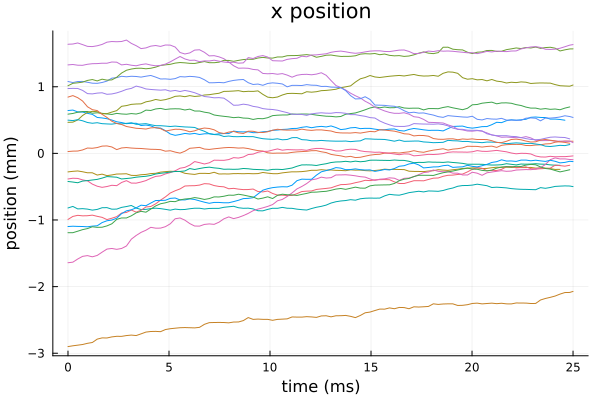

In [94]:
plot(legend=false, title="x position", xlabel="time (ms)",ylabel="position (mm)")
for j in trapped_indicies
   plot!(times[j], x_trajectories[j])
end
plot!()

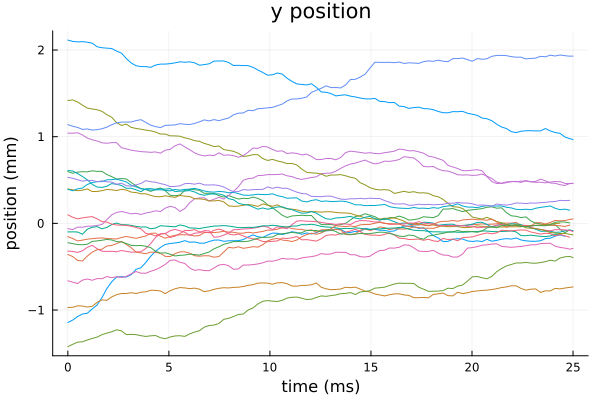

In [95]:
plot(legend=false, title="y position", xlabel="time (ms)",ylabel="position (mm)")
for j in trapped_indicies
   plot!(times[j], y_trajectories[j])
end
plot!()

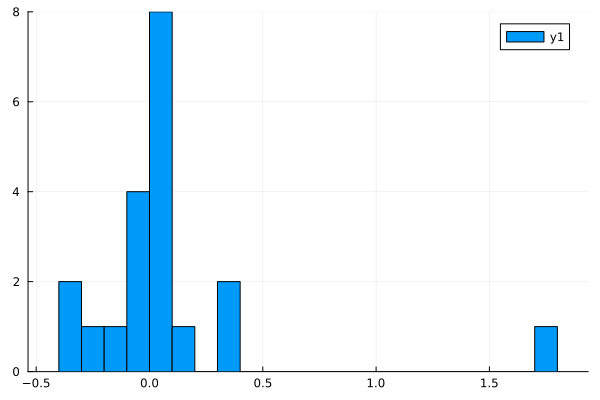

In [168]:
histogram([trajectory[end] for trajectory ∈ z_trajectories])

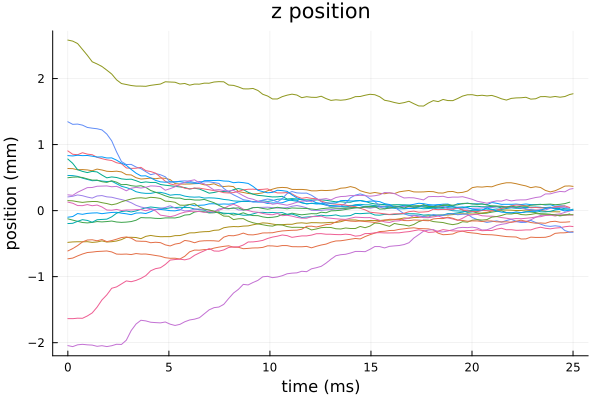

In [96]:
plot(legend=false, title="z position", xlabel="time (ms)",ylabel="position (mm)")
for j in trapped_indicies
   plot!(times[j], z_trajectories[j])
end
plot!()

## Motion of the centre of the cloud

In [164]:
function cloud_size(trajectories, trapped_indices, i) 
    size = 0.0
    counts = 0
    traj_values = Float64[]
    for trajectory ∈ trajectories[trapped_indices]
        if length(trajectory) >= i
            push!(traj_values, trajectory[i])
            size += sqrt(trajectory[i]^2)
            counts += 1
        end
    end
    size /= counts
    # return std(traj_values)
    return size
end;         

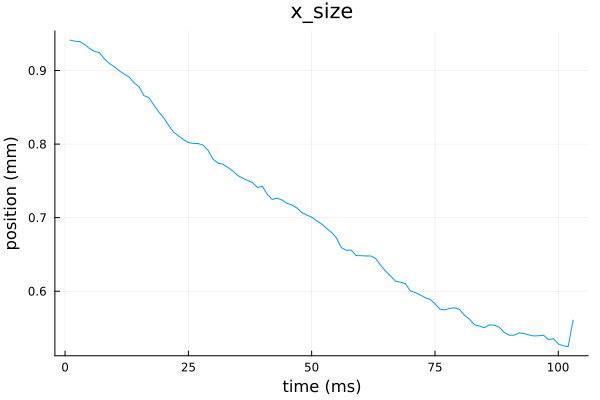

In [165]:
plot(legend=false, title="x_size", xlabel="time (ms)", ylabel="position (mm)")
σ_x = Float64[]

for i in 1:length(x_trajectories[1])
   # push!(σ_x, std([x_trajectories[j][i] for j in trapped_indicies]))
    push!(σ_x, cloud_size(x_trajectories, trapped_indicies, i))
end
plot!(σ_x)

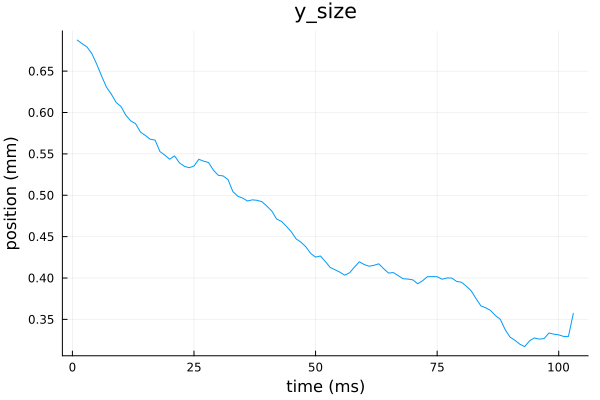

In [166]:
plot(legend=false, title="y_size", xlabel="time (ms)", ylabel="position (mm)")
σ_y = Float64[]

for i in 1:length(x_trajectories[1])
   # push!(σ_x, std([x_trajectories[j][i] for j in trapped_indicies]))
    push!(σ_y, cloud_size(y_trajectories, trapped_indicies, i))
end
plot!(σ_y)

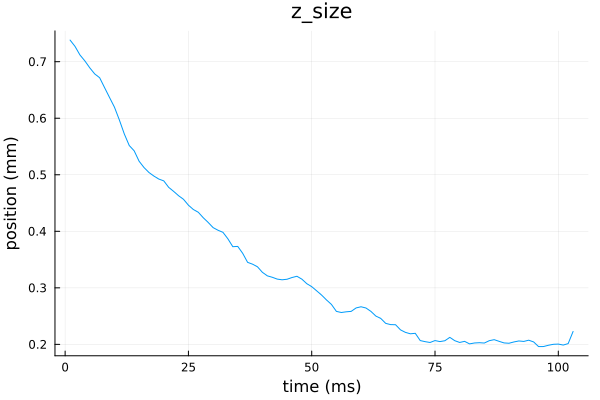

In [167]:
plot(legend=false, title="z_size", xlabel="time (ms)", ylabel="position (mm)")
σ_z = Float64[]

for i in 1:length(x_trajectories[1])
    push!(σ_z, cloud_size(z_trajectories, trapped_indicies, i))
end
plot!(σ_z)

Final temperature = 1.18e-04 K

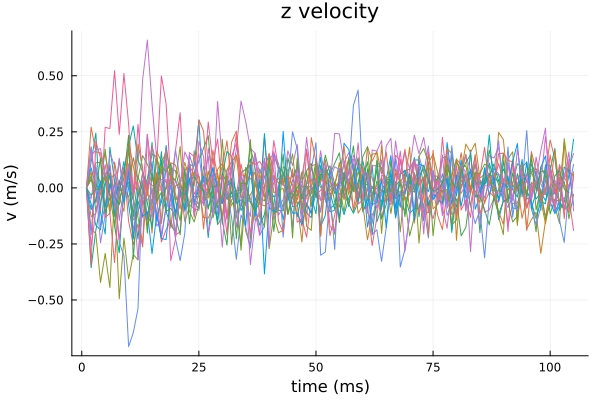

In [146]:
plot(legend=false, title="z velocity", xlabel="time (ms)",ylabel="v (m/s)")
v_end = Float64[]
for j in trapped_indicies
   plot!(z_velocities[j]) 
   push!(v_end, z_velocities[j][end])
end

v2 = std(v_end)^2

k_B = 1.381e-23
@printf("Final temperature = %.2e K", m*v2/k_B)
plot!()

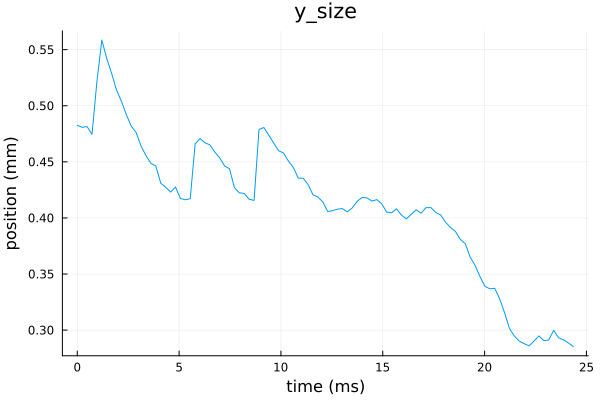

In [147]:
plot(legend=false, title="y_size", xlabel="time (ms)",ylabel="position (mm)")
σ_y = Float64[]

for i in 1:common_length
   push!(σ_y, std([y[i] for y in y_trajectories if abs(y[i]) < 1]))
end
plot!(times[1][1:common_length], σ_y)

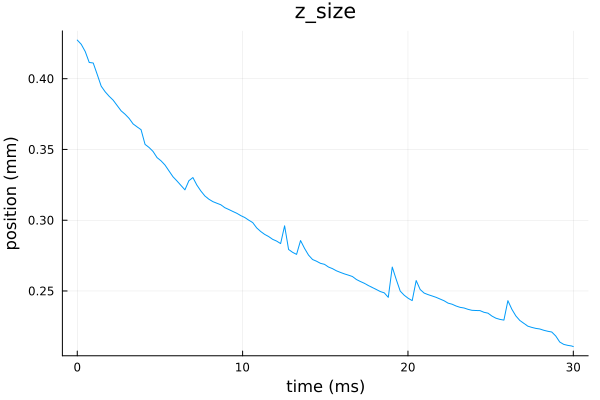

In [66]:
plot(legend=false, title="z_size", xlabel="time (ms)",ylabel="position (mm)")
σ_z = Float64[]

for i in 1:common_length
   push!(σ_z, std([z[i] for z in z_trajectories  if abs(z[i]) < 1]))
end
plot!(times[1][1:common_length], σ_z)

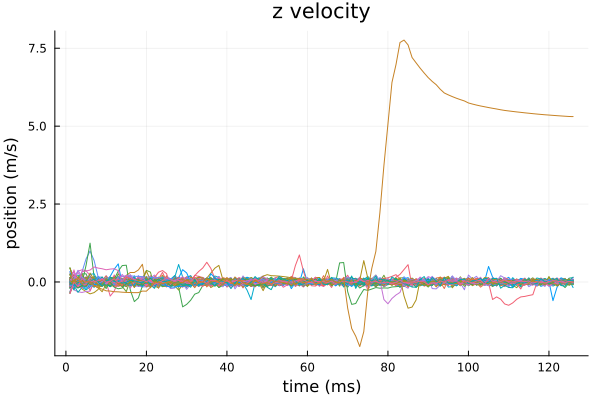

In [70]:
plot(legend=false, title="z velocity", xlabel="time (ms)",ylabel="position (m/s)")
for j in 1:length(z_trajectories)
   plot!(z_velocities[j]) 
end
plot!()

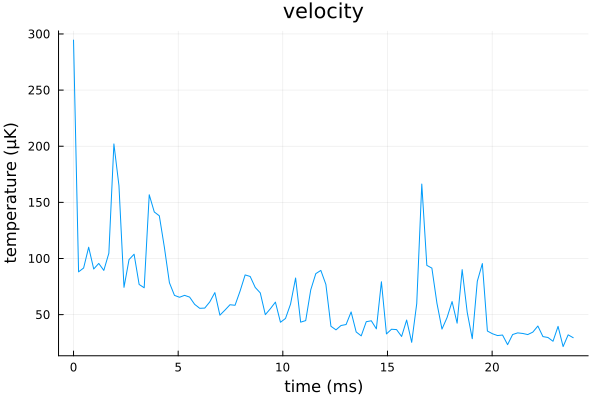

In [60]:
plot(legend=false, title="velocity", xlabel="time (ms)",ylabel="temperature (μK)")
σ_v = []
for i in 1:100
   push!(σ_v, std([v[i] for v in x_velocities]))
end
plot!(times[1][1:100], m*σ_v.^2/k_B*1e6)

In [61]:
equilibrium_velocities = zeros(Float64,0)
for v_particle in x_velocities
   equilibrium_velocities = [equilibrium_velocities; v_particle[end - length(times[1])÷2: end]] 
end

v2 = std(equilibrium_velocities)^2

k_B = 1.381e-23
@printf("Final temperature = %.2e K", m*v2/k_B)
;

Final temperature = 4.02e-05 K

Final temperature = 2.27e-05 K

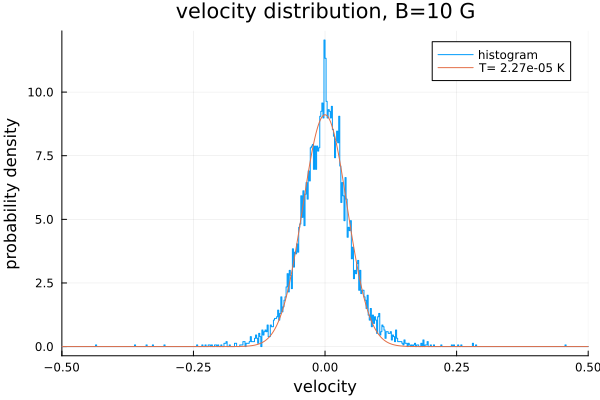

In [62]:
plot(legend=true, xlabel="velocity", ylabel="probability density", title="velocity distribution, B=10 G")
v2 = std(equilibrium_velocities)^2


x = stephist!(equilibrium_velocities, normalize=:pdf, label="histogram", nbins=1000)

hist_data = fit(Histogram, equilibrium_velocities, nbins=1000)
hist_data.isdensity = true
v = collect(hist_data.edges[1])
dv = v[2]-v[1]
v = v[1:end-1] .+ dv/2
fv = hist_data.weights ./ (sum(hist_data.weights) * dv)

v_fit = curve_fit(Gaussian, v, fv, [0.01, 0, 50])
σ, x0, A = v_fit.param

k_B = 1.381e-23
fit_T = m*σ^2/k_B
@printf("Final temperature = %.2e K", fit_T)

plot!(v, Gaussian(v, v_fit.param), label=@sprintf("T= %.2e K", fit_T))
plot!(xlim=(-0.5,0.5))

Final temperature = 2.27e-05 K

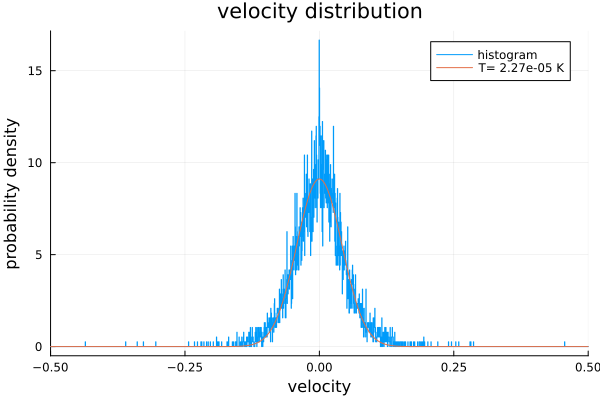

In [63]:
plot(legend=true, xlabel="velocity", ylabel="probability density", title="velocity distribution")
v2 = std(equilibrium_velocities)^2


x = stephist!(equilibrium_velocities, normalize=:pdf, label="histogram", nbins=4000)

hist_data = fit(Histogram, equilibrium_velocities, nbins=4000)
hist_data.isdensity = true
v = collect(hist_data.edges[1])
dv = v[2]-v[1]
v = v[1:end-1] .+ dv/2
fv = hist_data.weights ./ (sum(hist_data.weights) * dv)

v_fit = curve_fit(Gaussian, v, fv, [0.01, 0, 50])
σ, x0, A = v_fit.param

k_B = 1.381e-23
fit_T = m*σ^2/k_B
@printf("Final temperature = %.2e K", fit_T)

plot!(v, Gaussian(v, v_fit.param), label=@sprintf("T= %.2e K", fit_T))
plot!(xlim=(-0.5,0.5))

Final temperature = 2.27e-05 K

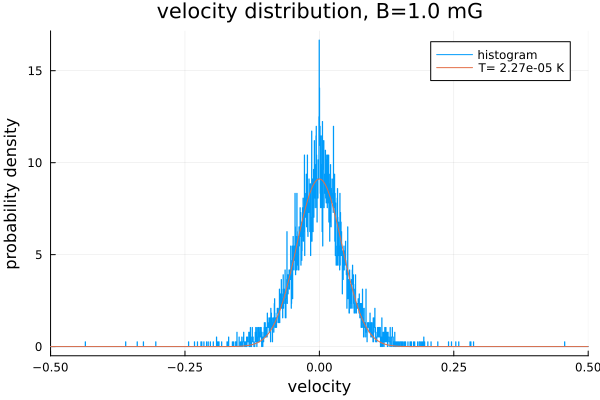

In [64]:
plot(legend=true, xlabel="velocity", ylabel="probability density", title="velocity distribution, B=1.0 mG", xlim=[-1,1])
v2 = std(equilibrium_velocities)^2


x = stephist!(equilibrium_velocities, normalize=:pdf, label="histogram", nbins=4000)

hist_data = fit(Histogram, equilibrium_velocities, nbins=4000)
hist_data.isdensity = true
v = collect(hist_data.edges[1])
dv = v[2]-v[1]
v = v[1:end-1] .+ dv/2
fv = hist_data.weights ./ (sum(hist_data.weights) * dv)

v_fit = curve_fit(Gaussian, v, fv, [0.01, 0, 50])
σ, x0, A = v_fit.param

k_B = 1.381e-23
fit_T = m*σ^2/k_B
@printf("Final temperature = %.2e K", fit_T)

plot!(v, Gaussian(v, v_fit.param), label=@sprintf("T= %.2e K", fit_T))
plot!(xlim=(-0.5,0.5))

Final temperature = 2.80e-05 K

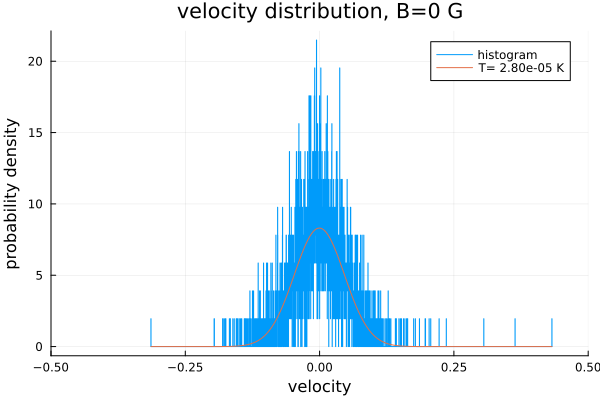

In [45]:
plot(legend=true, xlabel="velocity", ylabel="probability density", title="velocity distribution, B=0 G")
v2 = std(equilibrium_velocities)^2


x = stephist!(equilibrium_velocities, normalize=:pdf, label="histogram", nbins=4000)

hist_data = fit(Histogram, equilibrium_velocities, nbins=4000)
hist_data.isdensity = true
v = collect(hist_data.edges[1])
dv = v[2]-v[1]
v = v[1:end-1] .+ dv/2
fv = hist_data.weights ./ (sum(hist_data.weights) * dv)

v_fit = curve_fit(Gaussian, v, fv, [0.01, 0, 50])
σ, x0, A = v_fit.param

k_B = 1.381e-23
fit_T = m*σ^2/k_B
@printf("Final temperature = %.2e K", fit_T)

plot!(v, Gaussian(v, v_fit.param), label=@sprintf("T= %.2e K", fit_T))
plot!(xlim=(-0.5,0.5))

Final temperature = 2.80e-05 K

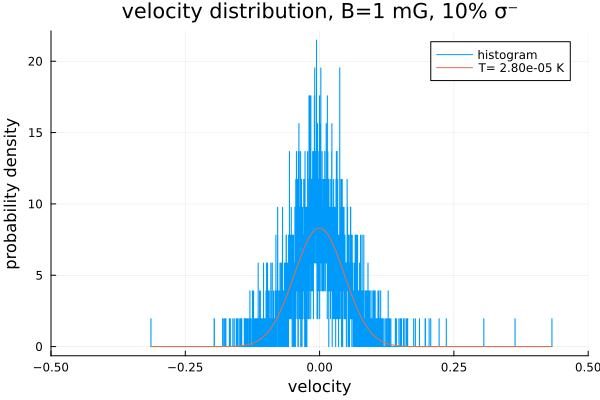

In [46]:
plot(legend=true, xlabel="velocity", ylabel="probability density", title="velocity distribution, B=1 mG, 10% σ⁻")
v2 = std(equilibrium_velocities)^2


x = stephist!(equilibrium_velocities, normalize=:pdf, label="histogram", nbins=4000)

hist_data = fit(Histogram, equilibrium_velocities, nbins=4000)
hist_data.isdensity = true
v = collect(hist_data.edges[1])
dv = v[2]-v[1]
v = v[1:end-1] .+ dv/2
fv = hist_data.weights ./ (sum(hist_data.weights) * dv)

v_fit = curve_fit(Gaussian, v, fv, [0.01, 0, 50])
σ, x0, A = v_fit.param

k_B = 1.381e-23
fit_T = m*σ^2/k_B
@printf("Final temperature = %.2e K", fit_T)

plot!(v, Gaussian(v, v_fit.param), label=@sprintf("T= %.2e K", fit_T))
plot!(xlim=(-0.5,0.5))

Final temperature = 2.80e-05 K

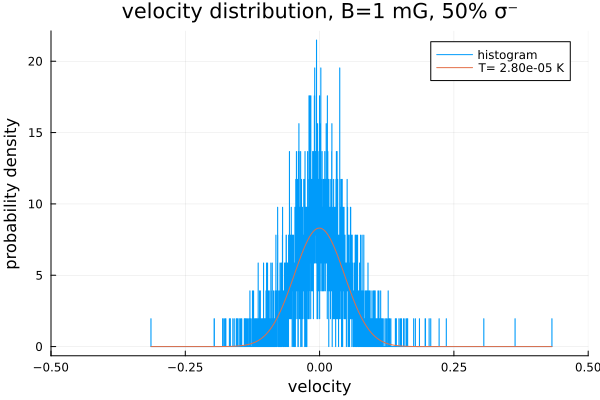

In [33]:
plot(legend=true, xlabel="velocity", ylabel="probability density", title="velocity distribution, B=1 mG, 50% σ⁻")
v2 = std(equilibrium_velocities)^2


x = stephist!(equilibrium_velocities, normalize=:pdf, label="histogram", nbins=4000)

hist_data = fit(Histogram, equilibrium_velocities, nbins=4000)
hist_data.isdensity = true
v = collect(hist_data.edges[1])
dv = v[2]-v[1]
v = v[1:end-1] .+ dv/2
fv = hist_data.weights ./ (sum(hist_data.weights) * dv)

v_fit = curve_fit(Gaussian, v, fv, [0.01, 0, 50])
σ, x0, A = v_fit.param

k_B = 1.381e-23
fit_T = m*σ^2/k_B
@printf("Final temperature = %.2e K", fit_T)

plot!(v, Gaussian(v, v_fit.param), label=@sprintf("T= %.2e K", fit_T))
plot!(xlim=(-0.5,0.5))

# Comparison to Monte Carlo simulations with OBE

In [40]:
particle = Particle()
ρ0 = zeros(ComplexF64, length(H.states), length(H.states))
ρ0[3,3] = 1.0
freq_res = 1e-2

p = obe(ρ0, particle, H.states, lasers, d, d, true, true, λ, Γ, freq_res, nothing)

t_end = 10p.period
tspan = (0., t_end)
prob = ODEProblem(ρ!, p.ρ0_vec, tspan, p)
callback = PeriodicCallback(reset_force!, prob.p.period)

prob.p.r0 = (0., 0., 0.4) .* 2π
prob.p.v = (0., 0., 0.0)
@time sol = DifferentialEquations.solve(prob, alg=DP5(), reltol=1e-5, abstol = 1e-5, callback=callback)
prob.p.force_last_period .* (ħ * k * Γ / m)*1e-3

using Plots
plot_us = sol.u#[1:10:end]
plot_ts = sol.t#[1:10:end]

n_states = size(p.ρ_soa, 1)
plot(size=(800, 400), ylim=(-0.1, 1.1), legend=nothing)
for i in 1:n_states
    state_idx = n_states*(i-1) + i
    plot!(plot_ts, [real(u[state_idx]) for u in plot_us])
end
plot!(legend=true)
offset = 0
vline!([sol.t[end] - prob.p.period - offset, sol.t[end] - offset], color="red", linestyle=:dash)

LoadError: UndefVarError: `H` not defined

In [ ]:


function prob_func!(prob, scan_params, i)
    p = prob.p
    
    # Update velocity and position
    p.particle.v .= scan_params[i].v
    p.particle.r0 .= scan_params[i].r
    
    
    # Update magnetic field
    H = p.extra_p.H
    H.parameters.B_z = scan_params[i].B
    evaluate!(H)
    QuantumStates.solve!(H)
    
    # Update transition dipole moments
    update_basis_tdms!(H)
    update_tdms!(H)
    new_d = H.tdms
    
    s = p.extra_p.s
    ω1 = p.extra_p.ω1
    
    k̂ = +x̂; ϵ1 = exp(im*scan_params[i].θx) *rotate_pol(σ⁺, k̂); ϵ_func1 = ϵ_(ϵ1); laser1 = Field(k̂, ϵ_func1, ω1, s)
    k̂ = -x̂; ϵ2 = exp(im*scan_params[i].θx) *rotate_pol(σ⁺, k̂); ϵ_func2 = ϵ_(ϵ2); laser2 = Field(k̂, ϵ_func2, ω1, s)

    k̂ = +ŷ; ϵ3 = exp(im*scan_params[i].θy) * rotate_pol(σ⁺, k̂); ϵ_func3 = ϵ_(ϵ3); laser3 = Field(k̂, ϵ_func3, ω1, s)
    k̂ = -ŷ; ϵ4 = exp(im*scan_params[i].θy) *rotate_pol(σ⁺, k̂); ϵ_func4 = ϵ_(ϵ4); laser4 = Field(k̂, ϵ_func4, ω1, s)

    k̂ = +ẑ; ϵ5 = rotate_pol(σ⁺, k̂);  ϵ_func5 = ϵ_(ϵ5); laser5 = Field(k̂, ϵ_func5, ω1, s)
    k̂ = -ẑ; ϵ6 = rotate_pol(σ⁺, k̂);  ϵ_func6 = ϵ_(ϵ6); laser6 = Field(k̂, ϵ_func6, ω1, s)

    lasers = [laser1, laser2, laser3, laser4, laser5, laser6]
    new_p = obe(p.ρ0, p.particle, H.states, lasers, new_d, nothing, true, true, p.λ, p.Γ, p.freq_res, p.extra_p)
    
    
    return remake(prob, p=new_p)
end

function output_func(p, sol)
    f = p.force_last_period
    return f
end
;

In [ ]:
ρ0 = zeros(ComplexF64, length(H.states), length(H.states))
ρ0[3,3] = 1.0

t_end = 10p.period
tspan = (0., t_end)

using RectiGrids

freq_res = 1e-2
extra_p = (H=H, lasers=lasers, ω1 = ω1, s = s)
p = obe(ρ0, particle, H.states, lasers, d, d, true, true, λ, Γ, freq_res, extra_p)

t_end = 10p.period+1; tspan = (0., t_end)
prob = ODEProblem(ρ!, p.ρ0_vec, tspan, p, reltol=1e-3, save_on=false)

di = 5
rs = vcat([(n1*λ/(di+1), n2*λ/(di+1), n3*λ/(di+1)) .* 2π for n1 ∈ 0:di, n2 ∈ 0:di, n3 ∈ 0:di]...)
vzs = LinRange(0,15/(Γ/k),100)
vs = []
for vz in vzs
    push!(vs, [0,0,vz])
end

# vs = [sample_direction(0.0) for _ in 1:1]


scan_values = (B = [0.0], r = rs, v = vs, θx = [0.0], θy = [0.0])
scan_values_grid = RectiGrids.grid(scan_values)

@time forces, populations = force_scan_v2(prob, scan_values_grid, prob_func!, output_func);

averaged_forces = []
averaged_A_populations = []
@time for (i,vz) ∈ enumerate(vzs)
    idxs = [j for (j,x) ∈ enumerate(scan_values_grid) if x.v[3] == vz]
    push!(averaged_forces, mean([f[3] for f in forces[idxs]]))
    push!(averaged_A_populations, mean(populations[idxs, 4:6])*3)
end

In [ ]:
plot(xlabel="velocity (m/s)", ylabel="Acceleration (m/s²)",size=(400,250))
plot!(vzs.*(Γ/k), averaged_forces.* (ħ * k * Γ / m))

In [ ]:
# plot(vzs.*(Γ/k), averaged_A_populations,size=(400,250))

In [ ]:
include("G:\\My Drive\\github\\BlueDetunedMOTSimulations\\CaOH_simulation_toolbox.jl");
using Interpolations, BeamPropagation
;

In [ ]:
scan_values = Dict{String, Vector{Float64}}("B"=>[-1000,1000], "v"=>vzs)
acceleration = zeros(2,length(averaged_forces))
A_populations = zeros(2,length(averaged_forces))

acceleration[1,:] = acceleration[2,:] = averaged_forces.*(ħ * k * Γ / m)
A_populations[1,:] = A_populations[2,:] = averaged_A_populations

acceleration_grids = make_grids(scan_values, acceleration)
A_population_grids = make_grids(scan_values, A_populations)



# Interpolate (in SI units)
B_range = range(scan_values["B"][1],scan_values["B"][end], length=length(scan_values["B"]))
v_range = range(scan_values["v"][1]* (Γ / k),scan_values["v"][end]* (Γ / k), length=length(scan_values["v"]))
        

nodes = (scan_values["B"], scan_values["v"].* (Γ / k))
acceleration_func = interpolate(nodes, acceleration_grids, Gridded(Linear()))
A_population_func = interpolate(nodes, A_population_grids, Gridded(Linear()))     
A_population_func = extrapolate(A_population_func, Flat());


In [ ]:
# y = scan_values["v"].* (Γ / k)
# B_fixed = 1
# plot(xlabel="velocity (m/s)", ylabel="Acceleration (m/s²)",size=(400,250))
# plot!(y, acceleration_func(-100,y) , label=@sprintf("B = %.1f G", B_fixed) )
# plot!()

In [ ]:
function update(particles, p, s, dt, time, idx)
    hbar = 1.05457182e-34 
    for i in 1:size(particles, 1)
        B = particles.r[i][3] * p.B_gradient
        v = particles.v[i]
        Pe = p.A_population_func(B * sign(v[3]), abs(v[3]))
        scattering_prob = dt * Γ * Pe
        if rand() < scattering_prob 
            v_rand = sample_direction(hbar * k / m) * 1
            particles.v[i] += SVector(0,0,v_rand[3])
            # if rand() < 0.5
            #     particles.v[i] += sample_direction(hbar * k / m) # SVector(0,0,hbar * k / m)
            # else
            #     particles.v[i] -= SVector(0,0,hbar * k / m)
            # end
        end
    end
    return nothing
end

function init_1D_MOT_distribution(T, diameter)
    kB = 1.381e-23
    m = @with_unit 57 "u"
    σ = sqrt(kB * T / m)
    
    r = (Normal(0, diameter), Normal(0, diameter), Normal(0, diameter))
    v = (Normal(0, σ), Normal(0, σ), Normal(0, σ))
    a = (Normal(0, 0), Normal(0, 0), Normal(0, 0))
    return r, v, a
end

function init_isotropic_MOT_distribution(T, diameter)
    kB = 1.381e-23
    m = @with_unit 57 "u"
    σ = sqrt(kB * T / m)
    
    r = Normal(0, diameter)
    v = Normal(0, σ)
    return r, v
end


function discard_particles!(particles, discard)
    @inbounds for i in 1:size(particles, 1)
        particles.dead[i] = discard(particles.r[i], particles.v[i])
    end
    StructArrays.foreachfield(x -> deleteat!(x, particles.dead), particles)
    return nothing
end

function discard_out_of_bound(r, v)
    if abs(r[3]) > abs( maximum(scan_values["B"]) / B_gradient )
        return true
    elseif abs(v[3]) > abs( maximum(scan_values["v"])* (Γ / k))
        return true
    else
        return false
    end
end

In [ ]:
import BeamPropagation.Particle
import StructArrays: StructArray, StructVector
using StructArrays

B_gradient = 0
n = 1000
save_every = 3000
delete_every = 100
dt_min = 1e-10
dt_max = 1e-4
abstol = 1e-5
dt = 1e-8
total_time = @with_unit 5 "ms"
max_steps = Int64(ceil(total_time / dt))
alg = "rkf12"
use_adaptive = false
dt0 = 1e-5
times = (0:dt:max_steps * dt)[1:save_every:end-1]


particles = StructArray{BeamPropagation.Particle}(undef, n)
trajectories = [SVector{3, Float64}[] for _ ∈ 1:length(particles)]
velocities = [SVector{3, Float64}[] for _ ∈ 1:length(particles)]
A_populations = [SVector{1, Float64}[] for _ ∈ 1:length(particles)]

temp = @with_unit 1 "mK"
diameter = @with_unit 0.6 "mm"
r, v, a = init_1D_MOT_distribution(temp, diameter)



p = MutableNamedTuple(B_gradient=B_gradient, acceleration_func=acceleration_func, A_population_func = A_population_func)
mc_s = MutableNamedTuple(trajectories=trajectories, velocities = velocities, A_populations = A_populations)

@time propagate_particles!(r, v, a, 
    alg, particles, f, save, discard_out_of_bound, save_every, delete_every, max_steps, update, p, mc_s, dt, use_adaptive, 
    dt_min, dt_max, abstol, true
)



In [ ]:
plot(xlabel="time (ms)", ylabel="v (m/s)", legend=false)
for particle_id in 1:1:n
    particle_z_velocity = [mc_s.velocities[particle_id][i][3] for i in  eachindex(mc_s.trajectories[particle_id])]
    plot!(times[1:length(particle_z_velocity)] * 1e3, particle_z_velocity)
end

vs = []
i_half = length(times)÷2
for particle_id in 1:1:n
    push!(vs, mc_s.velocities[particle_id][i_half][3])
end
v = std(vs)

k_B = 1.381e-23
@printf("Final temperature = %.2e K", 1/2*m*v^2/k_B)


plot!()

In [ ]:
function add_B_to_A!(A::StructArray{<:Complex}, B::StructArray{<:Complex})
    @turbo for i ∈ eachindex(A)
        A.re[i] = A.re[i] + B.re[i]
        A.im[i] = A.im[i] + B.im[i]
    end
end

function add_B_to_A_with_scalar!(A::StructArray{<:Complex}, B::StructArray{<:Complex}, scalar::Float64)
    @turbo for i ∈ eachindex(A)
        A.re[i] = A.re[i] + scalar * B.re[i]
        A.im[i] = A.im[i] + scalar * B.im[i]
    end
end

### Copies of some private functions from OpticalBlochEquations package

In [ ]:
# Multiplication using `@turbo` from LoopVectorization
function mul_turbo!(C, A, B)
    @turbo for m ∈ 1:size(A,1), n ∈ 1:size(B,2)
        Cmn_re = 0.0
        Cmn_im = 0.0
        for k ∈ 1:size(A,2)
            A_mk_re = A.re[m,k]
            A_mk_im = A.im[m,k]
            B_kn_re = B.re[k,n]
            B_kn_im = B.im[k,n]
            Cmn_re += A_mk_re * B_kn_re - A_mk_im * B_kn_im
            Cmn_im += A_mk_re * B_kn_im + A_mk_im * B_kn_re
        end
        C.re[m,n] = Cmn_re
        C.im[m,n] = Cmn_im
    end
end

function mul_by_im!(C::StructArray{<:Complex})
    @turbo for i ∈ eachindex(C)
        a = C.re[i]
        C.re[i] = -C.im[i]
        C.im[i] = a
    end
end

function mul_by_im_minus!(C::StructArray{<:Complex})
    @turbo for i ∈ eachindex(C)
        a = C.re[i]
        C.re[i] = C.im[i]
        C.im[i] = -a
    end
end

function soa_to_base!(ρ::Array{<:Complex}, ρ_soa::StructArray{<:Complex})
    @inbounds for i in eachindex(ρ_soa)
        ρ[i] = ρ_soa.re[i] + im * ρ_soa.im[i]
    end
    return nothing
end

function base_to_soa!(ρ::Array{<:Complex}, ρ_soa::StructArray{<:Complex})
    @inbounds for i in eachindex(ρ_soa)
        ρ_soa.re[i] = real(ρ[i])
        ρ_soa.im[i] = imag(ρ[i])
    end
    return nothing
end

function base_to_soa_vec!(ρ::Array{<:Complex}, ρ_soa::StructArray{<:Complex})
    @inbounds for i in eachindex(ρ, ρ_soa)
        ρ_soa.re[i] = real(ρ[i])
        ρ_soa.im[i] = imag(ρ[i])
    end
    return nothing
end

function update_eiωt!(eiωt::StructArray{<:Complex}, ω::Array{<:Real}, τ::Real)
    @turbo for i ∈ eachindex(ω)
        eiωt.im[i], eiωt.re[i] = sincos( ω[i] * τ )
    end
    return nothing
end



In [ ]:
import OpticalBlochEquations.update_H!

function update_H(H, p, τ)
    @turbo for i in eachindex(H)
        H.re[i] = p.H₀.re[i]
        H.im[i] = p.H₀.im[i]
    end
    return nothing
end

function update_H!(p, τ, r, H₀, fields, H, E_k, ds, ds_state1, ds_state2, Js)

    p.update_H(H, p, τ)
    
    # @turbo for i in eachindex(H)
    #     H.re[i] = H₀.re[i]
    #     H.im[i] = H₀.im[i]
    # end
 
    update_fields!(fields, r, τ)

    # Set summed fields to zero
    p.E -= p.E
    @inbounds for i ∈ 1:3
        E_k[i] -= E_k[i]
    end
    
    # Sum updated fields
    @inbounds for i ∈ eachindex(fields)
        E_i = fields.E[i] * sqrt(fields.s[i]) / (2 * √2)
        k_i = fields.k[i]
        p.E += E_i
        for k ∈ 1:3
            E_k[k] += E_i * k_i[k]
        end
    end

    # This can be used to exclude very off-resonant terms, need to add a user-defined setting to determine behavior
    # @inbounds for i ∈ eachindex(fields)
    #     s = fields.s[i]
    #     ω_field = fields.ω[i]
    #     x = sqrt(s) / (2 * √2)
    #     @inbounds for q ∈ 1:3
    #         E_i_q = fields.E[i][q]
    #         if norm(E_i_q) > 1e-10
    #             d_nnz_q = d_nnz[q]
    #             d_q = @view d[:,:,q]
    #             @inbounds @simd for cart_idx ∈ d_nnz_q
    #                 m, n = cart_idx.I
    #                 if abs(ω_field - (ω[n] - ω[m])) < 100 # Do not include very off-resonant terms (terms detuned by >10Γ)
    #                     val = x * E_i_q * d_q[m,n]
    #                     H[m,n] += val
    #                     H[n,m] += conj(val)
    #                 end
    #             end
    #         end
    #     end
    # end

    @inbounds for q ∈ 1:3
        E_q = p.E[q]
        if norm(E_q) > 1e-10
            E_q_re = real(E_q)
            E_q_im = imag(E_q)
            ds_q = ds[q]
            ds_q_re = ds_q.re
            ds_q_im = ds_q.im
            ds_state1_q = ds_state1[q]
            ds_state2_q = ds_state2[q]
            @turbo for i ∈ eachindex(ds_q)
                m = ds_state1_q[i] # excited state
                n = ds_state2_q[i] # ground state
                d_re = ds_q_re[i]
                d_im = ds_q_im[i]
                val_re = E_q_re * d_re - E_q_im * d_im
                val_im = E_q_re * d_im + E_q_im * d_re
                H.re[n,m] += val_re
                H.im[n,m] += val_im
                H.re[m,n] += val_re
                H.im[m,n] -= val_im
            end
        end
    end

    # Is this version faster?
    # @inbounds for q ∈ 1:3
    #     E_q = p.E[q]
    #     if norm(E_q) > 1e-10
    #         d_nnz_q = d_nnz[q]
    #         d_q = @view d[:,:,q]
    #         @inbounds @simd for cart_idx ∈ d_nnz_q
    #             m, n = cart_idx.I
    #             val = E_q * d_q[m,n]
    #             H[m,n] += val
    #             H[n,m] += conj(val)
    #         end
    #     end
    # end

    for J ∈ Js
        rate = im * J.r^2 / 2
        H[J.s, J.s] -= rate
    end

    return nothing
end

round_to_mult(val, prec) = round.(val ./ prec) .* prec

function round_freq(ω, freq_res)
    ω_min = freq_res
    return round_to_mult(ω, ω_min)
end
export round_freq



function round_v_by_norm(v, digits)
    v_norm = norm(v)
    return v ./ (v_norm / round(v_norm, digits=digits))
end

function round_freqs!(states, fields, freq_res)
    """
    Rounds frequencies of state energies and fields by a common denominator.
    
    freq_res::Float: all frequencies are rounded by this value (in units of Γ)
    """
    for i in eachindex(fields)
        fields.ω[i] = round_freq(fields.ω[i], freq_res)
    end
    for i in eachindex(states)
        states.E[i] = round_freq(states.E[i], freq_res)
    end
    return nothing
end


In [ ]:
F = 1
F′ = 1
J_mat = zeros(2F+1 + 2F′+1,2F+1 + 2F′+1)
for i in 1:2F+1
    M = -F-1+i
    for j in 2F+2:2F+1+2F′+ 1
        M′ = -F′-1+ (j - 2F - 1)
        for p in -1:1:1
            J_mat[i,j] += norm(wigner3j(F, 1, F′, M, -p, -M′))^2
        end
    end
end
J_mat

In [ ]:
Ux = [[1/2, -1/sqrt(2), 1/2],
    [-1/sqrt(2),0,1/sqrt(2)],
    [1/2, 1/sqrt(2), 1/2]]

Ux = mapreduce(permutedims, vcat, Ux)

U = zeros(2F+1 + 2F′+1,2F+1 + 2F′+1)